### Questions

{} What is the average daily steps, calories, workout minutes, and sleep hours?

{} Which weekday has the highest average steps?

{} Which month do you burn the most calories?

{} How many days did you meet the 10,000 steps goal?

{} Are your steps increasing/decreasing over months?

{} Does your average sleep change across weekdays (e.g., less sleep on weekends)?

{} On which month did you work out the most?

{} Do more steps = more calories burned? (Check correlation).

{} Does longer workout time → better sleep?

{} Does less sleep → higher heart rate the next day?

{} Does higher water intake → lower heart rate (hydration effect)?

{} “You are most active on Saturdays, averaging X steps.”

{} “Your sleep is lowest on Mondays, only Y hours on average.”

{} “Your average steps this month increased by Z% compared to last month.”

{} “When you work out for more than 60 mins, your average heart rate decreases by N bpm.”

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [51]:
df = pd.read_csv("fitness_dashboard_data.csv", parse_dates=["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            500 non-null    datetime64[ns]
 1   Month           500 non-null    object        
 2   Weekday         500 non-null    object        
 3   Steps           500 non-null    int64         
 4   Calories        500 non-null    int64         
 5   WorkoutMinutes  500 non-null    float64       
 6   SleepHours      500 non-null    float64       
 7   WaterIntake(L)  500 non-null    float64       
 8   HeartRate       500 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 35.3+ KB


In [52]:
df.head()

,Date,Month,Weekday,Steps,Calories,WorkoutMinutes,SleepHours,WaterIntake(L),HeartRate
0,2023-01-01,January,Sunday,18122,2877,66.000,10.0,1.59,76
1,2023-01-02,January,Monday,12538,3989,103.000,5.6,2.49,69
2,2023-01-03,January,Tuesday,10994,3877,117.000,6.1,2.19,64
3,2023-01-04,January,Wednesday,19074,2926,60.662,6.0,1.63,104
4,2023-01-05,January,Thursday,18948,2004,11.000,8.2,2.82,95


In [53]:
avg_steps = int(df['Steps'].mean())
avg_cal = int(df['Calories'].mean())
avg_min = int(df['WorkoutMinutes'].mean())
avg_sleep = int(df['SleepHours'].mean())

#### Ques --> What's related to what ?

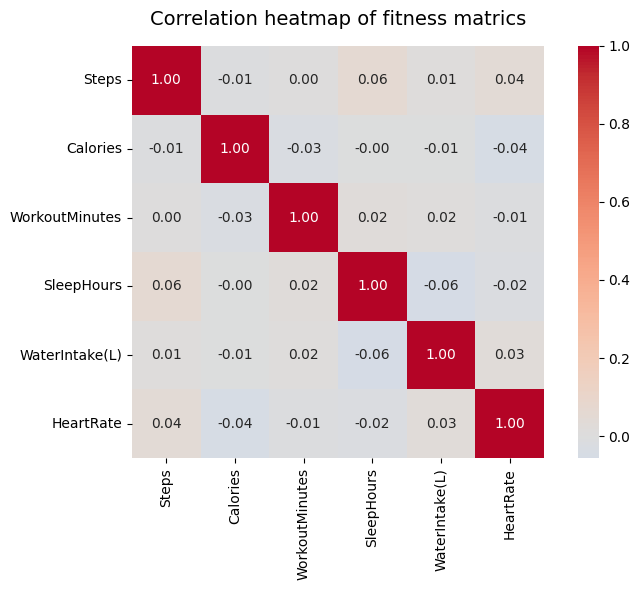

In [54]:
# Which factors are most connected in my life?
numeric_df = df.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True, cmap="coolwarm",center=0,square=True, fmt=".2f")
plt.title("Correlation heatmap of fitness matrics",fontsize=14,pad=15)
plt.tight_layout()
plt.show()

#### Ques -> How do activity pattern evolve across time?

In [55]:
weekly = df.set_index("Date").resample("W").sum().reset_index()
metrics = ["Steps","Calories","WorkoutMinutes","WaterIntake(L)"]

fig = px.area(
    weekly,
    x="Date",
    y = metrics,
    title= "Weekly Activity Breakdown",
    labels={"value":"Total Activity","Date":"Week"},
)
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Total Activity",
    legend_title="Metric",
    template="plotly_white"
)
fig.show()

### Ques --> Am i balanced acorss different matrics ?

In [56]:
metrics1 = ["Steps","Calories","WaterIntake(L)","WorkoutMinutes","SleepHours"]

df_norm = df.copy()
for col in metrics:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Extract month name
df_norm["Month"] = pd.to_datetime(df_norm["Date"]).dt.strftime("%b")

# Average normalized values per month
monthly_avg = df_norm.groupby("Month")[metrics].mean().reset_index()

# Convert to long format for radar plot
radar = monthly_avg.melt(id_vars="Month", var_name="Metric", value_name="Value")

# Radar chart with multiple polygons (one per month)
fig = px.line_polar(
    radar,
    r="Value",
    theta="Metric",
    color="Month",
    line_close=True,
    title="Monthly Lifestyle Balance",
)

fig.update_traces(fill="toself", opacity=0.6)
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0,1])))

fig.show()

# i will try to make a dropdown menu later

In [57]:
fig = go.Figure()

# Add one trace per month, initially hidden except the first
for i, row in monthly_avg.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[metrics].values,
        theta=metrics,
        fill="toself",
        name=row["Month"],
        visible=(i == 0)  # Only first month visible
    ))

# Dropdown menu
buttons = []
for i, month in enumerate(monthly_avg["Month"]):
    visibility = [False] * len(monthly_avg)
    visibility[i] = True
    buttons.append(dict(label=month,
                        method="update",
                        args=[{"visible": visibility},
                              {"title": f"Lifestyle Balance - {month}"}]))

fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=buttons,
                      x=1.1, y=1.1)],
    polar=dict(radialaxis=dict(visible=True, range=[0,1])),
    title="Interactive Lifestyle Balance per Month"
)

fig.show()

### Ques --> When i am least/most active in the year?

In [58]:
df["Month"] = df["Date"].dt.strftime("%b")
df["Weekday"] = df["Date"].dt.day_name()

fig = px.density_heatmap(
    df,
    x="Weekday",          # Days on x-axis
    y="Month",            # Months on y-axis
    z="Steps",            # Color intensity
    histfunc="avg",       # Average steps per day
    color_continuous_scale="YlGnBu",
    title="Interactive Calendar Heatmap of Daily Steps"
)

fig.update_layout(
    xaxis={"categoryorder":"array", "categoryarray":["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]},
    yaxis={"categoryorder":"array", "categoryarray":["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]}
)

fig.show()

### Ques --> Comparing different parameters on same timeline?

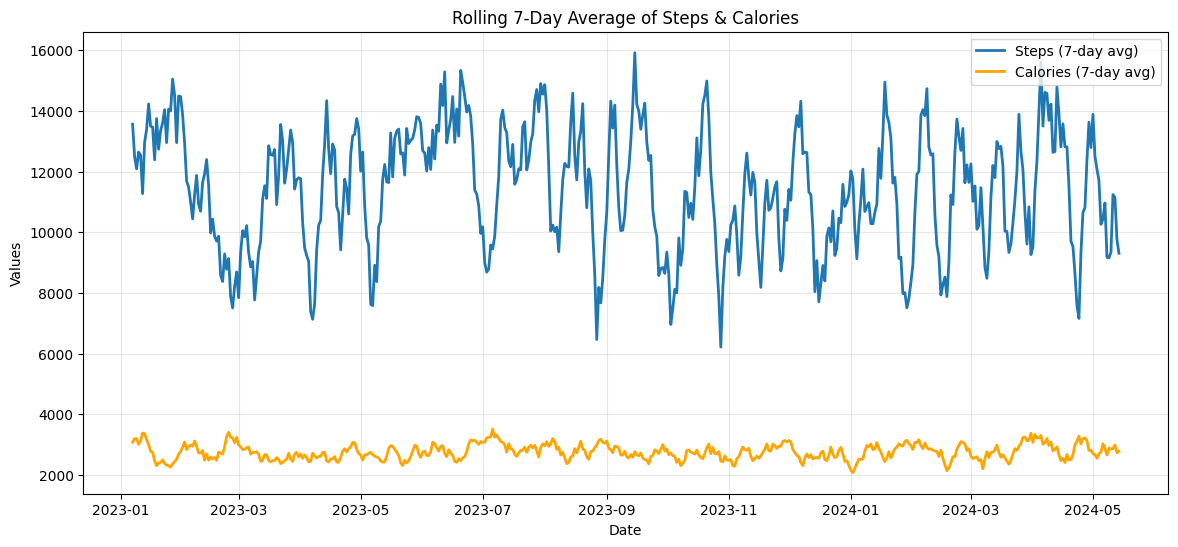

In [59]:
df["Steps_Roll"] = df["Steps"].rolling(window=7).mean()
df["Calories_Roll"] = df["Calories"].rolling(window=7).mean()

plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Steps_Roll"], label="Steps (7-day avg)", linewidth=2)
plt.plot(df["Date"], df["Calories_Roll"], label="Calories (7-day avg)", linewidth=2, color="orange")

plt.title("Rolling 7-Day Average of Steps & Calories")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [60]:
df_long = df.melt(
    id_vars="Date",
    value_vars=["Steps_Roll", "Calories_Roll"],
    var_name="Metric",
    value_name="Value"
)

# Interactive line chart
fig = px.line(
    df_long,
    x="Date",
    y="Value",
    color="Metric",
    title="Interactive 7-Day Rolling Average of Steps & Calories",
    labels={"Value": "7-Day Rolling Average"}
)

fig.update_layout(
    hovermode="x unified",
    legend_title="Metric",
    xaxis=dict(rangeslider=dict(visible=True)) 
)

fig.show()